# **📊 LSTM RSS Prediction: Data Preprocessing & Exploratory Data Analysis**

## **1. Import Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import autocorrelation_plot


## **2. Load the Averaged 24-Hour RSS Dataset**
Explanation:
Load your dataset (CSV or Excel) into a DataFrame.
If using Google Colab, use the upload widget.

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload your file

# Replace with your actual filename if different
data = pd.read_csv('simulated_realistic_rss.csv')
data.head()

Saving simulated_realistic_rss.csv to simulated_realistic_rss.csv


,Timestamp,RSS
0,2025-02-18 06:00:00,-30.258607
1,2025-02-18 06:00:30,-27.280097
2,2025-02-18 06:01:00,-25.016969
3,2025-02-18 06:01:30,-31.398619
4,2025-02-18 06:02:00,-26.740359


## **3. Initial Data Inspection**
Explanation:
Check for missing values, data types, and a quick statistical summary to understand your data's shape and quality.

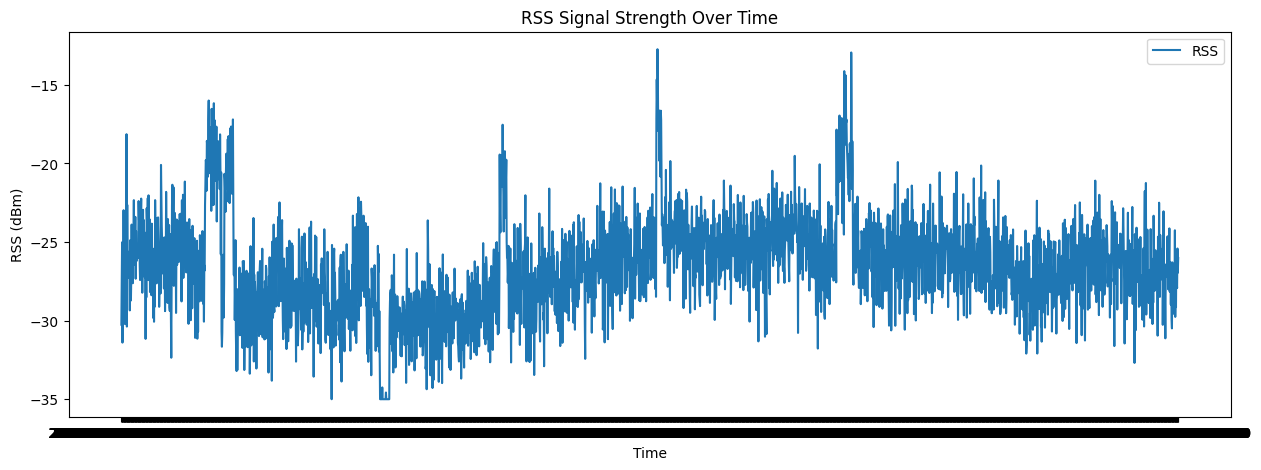

In [ ]:
# print("DataFrame Info:")
# print(data.info())
# print("\nMissing values:\n", data.isnull().sum())
# print("\nStatistical Summary:\n", data.describe())

# Plot to visualize
plt.figure(figsize=(15,5))
plt.plot(data['Timestamp'], data['RSS'], label='RSS')
plt.title('RSS Signal Strength Over Time')
plt.xlabel('Time')
plt.ylabel('RSS (dBm)')
plt.legend()
plt.show()


## **4. Data Cleaning**
Explanation:

Remove units from RSS if present (e.g., 'dBm').

Convert RSS to float.

Drop irrelevant columns (keep only timestamp and RSS).

Parse timestamps and sort chronologically.

In [ ]:
# Remove 'dBm' if present and convert to float
# Standardize column names (in case they shifted)
data.columns = data.columns.str.strip() # Strip leading/trailing spaces from column names

# Replace "Unknown" with NaN
data.replace("Unknown", np.nan, inplace=True)

# Drop completely empty columns
data.dropna(axis=1, how='all', inplace=True)

# Clean numeric columns (remove non-numeric characters like 'dBm' or 'Mbps')
if 'Signal Strength' in data.columns:
    data['Signal Strength'] = data['Signal Strength'].astype(str).str.extract(r'([-]?\d+\.?\d*)')[0]
    data['Signal Strength'] = pd.to_numeric(data['Signal Strength'], errors='coerce')


# Keep only necessary columns
# data = data[['Timestamp', 'Signal Strength']]  # Use the actual column name here as well
data = data[['Timestamp', 'RSS']]

# Rename the signal strength column for consistency
# data = data.rename(columns={"Signal Strength": 'RSS'})

# Parse datetime and sort
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
df = data.sort_values('Timestamp').reset_index(drop=True)

df.head()

,Timestamp,RSS
0,2025-02-18 06:00:00,-30.258607
1,2025-02-18 06:00:30,-27.280097
2,2025-02-18 06:01:00,-25.016969
3,2025-02-18 06:01:30,-31.398619
4,2025-02-18 06:02:00,-26.740359


## **5. Resampling and Handling Missing Data**
Explanation:

Ensure data is uniformly sampled (e.g., every 5 minutes).

Interpolate or fill missing values.

This is essential for time-series modeling.

In [ ]:
# Set timestamp as index for resampling
df.set_index('Timestamp', inplace=True)

df_1min = df.resample('1min').mean()  # '1T' is pandas offset alias for 1 minute
df_1min['RSS'] = df_1min['RSS'].interpolate()  # Fill missing values if any

df_5min = df.resample('5min').mean()
df_5min['RSS'] = df_5min['RSS'].interpolate()

df_10min = df.resample('10min').mean()
df_10min['RSS'] = df_10min['RSS'].interpolate()

# Reset index for plotting and further processing
df_1min.reset_index(inplace=True)
df_5min.reset_index(inplace=True)
df_10min.reset_index(inplace=True)

df_10min.head()

df.reset_index(inplace=True)


## **6. Feature Engineering**
Explanation:

Add time-based features if you want to analyze periodicity or trends (optional but insightful for EDA).

In [ ]:
df['hour'] = df['Timestamp'].dt.hour
df['minute'] = df['Timestamp'].dt.minute
df['dayofweek'] = df['Timestamp'].dt.dayofweek


## **7. Data Normalization**
Explanation:

LSTM models perform better with normalized data.

Use MinMaxScaler to scale RSS between 0 and 1.

In [ ]:
scaler_1min = MinMaxScaler()
df_1min['RSS_scaled'] = scaler_1min.fit_transform(df_1min[['RSS']])

scaler_5min = MinMaxScaler()
df_5min['RSS_scaled'] = scaler_5min.fit_transform(df_5min[['RSS']])

scaler_10min = MinMaxScaler()
df_10min['RSS_scaled'] = scaler_10min.fit_transform(df_10min[['RSS']])


## **8. Exploratory Data Analysis (EDA) & Visualization**
### **A. Line Plot: RSS Over Time**
Purpose:
Visualize overall trends, periodicity, and outliers in RSS.

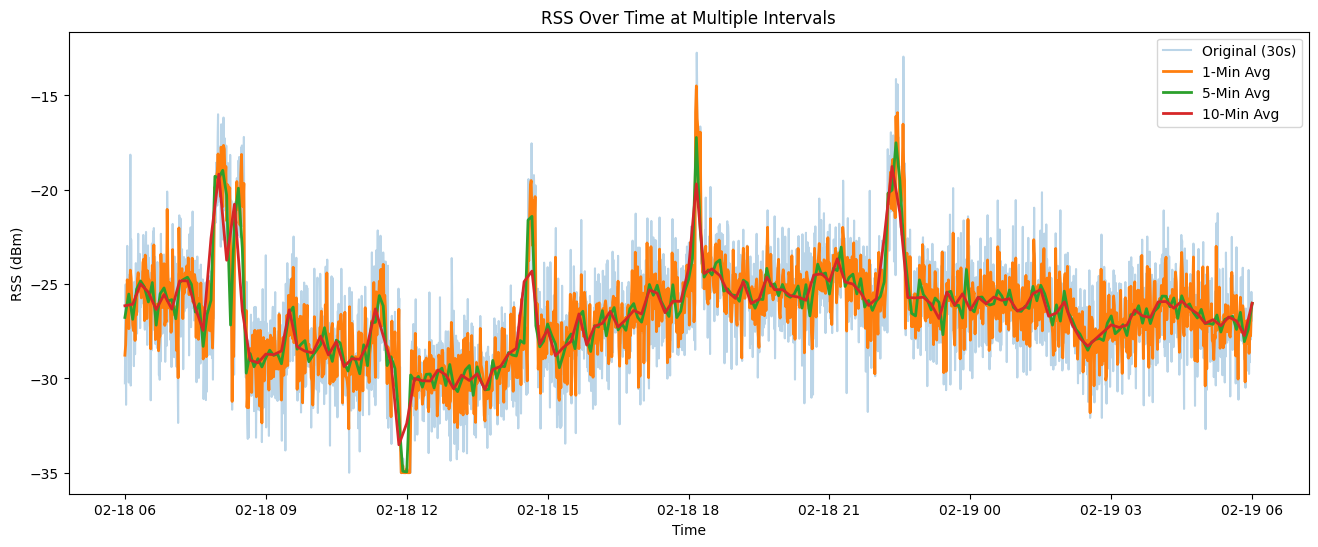

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df['Timestamp'], df['RSS'], label='Original (30s)', alpha=0.3)
plt.plot(df_1min['Timestamp'], df_1min['RSS'], label='1-Min Avg', linewidth=2)
plt.plot(df_5min['Timestamp'], df_5min['RSS'], label='5-Min Avg', linewidth=2)
plt.plot(df_10min['Timestamp'], df_10min['RSS'], label='10-Min Avg', linewidth=2)
plt.title('RSS Over Time at Multiple Intervals')
plt.xlabel('Time')
plt.ylabel('RSS (dBm)')
plt.legend()
plt.show()


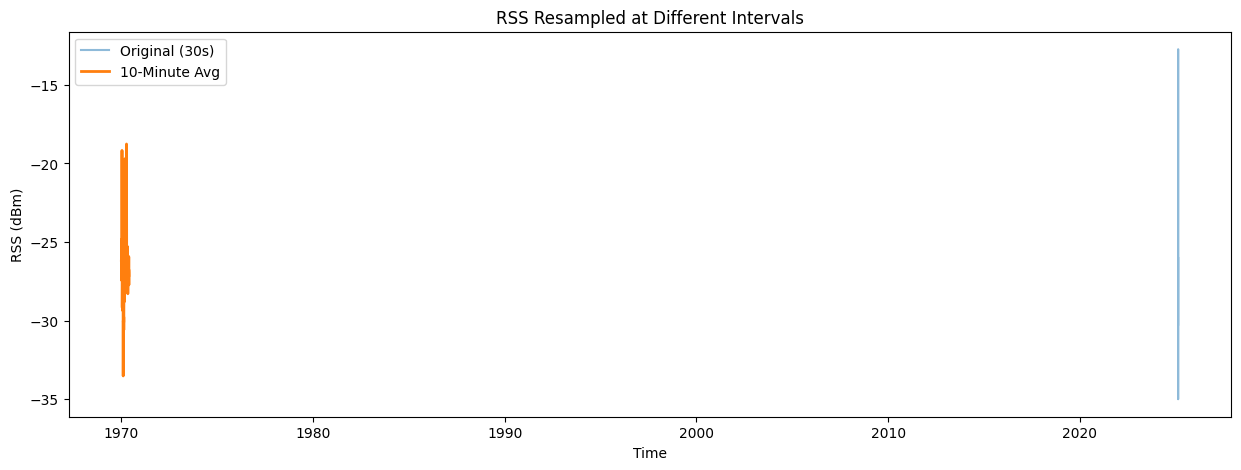

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['Timestamp'], df['RSS'], label='Original (30s)', alpha=0.5)
# plt.plot(df_1min['RSS'], label='1-Minute Avg', linewidth=2)
# plt.plot(df_5min['RSS'], label='5-Minute Avg', linewidth=2)
plt.plot(df_10min['RSS'], label='10-Minute Avg', linewidth=2)
plt.title('RSS Resampled at Different Intervals')
plt.xlabel('Time')
plt.ylabel('RSS (dBm)')
plt.legend()
plt.show()


### **B. Histogram & Density Plot**
Purpose:
Understand the distribution and spread of RSS values.

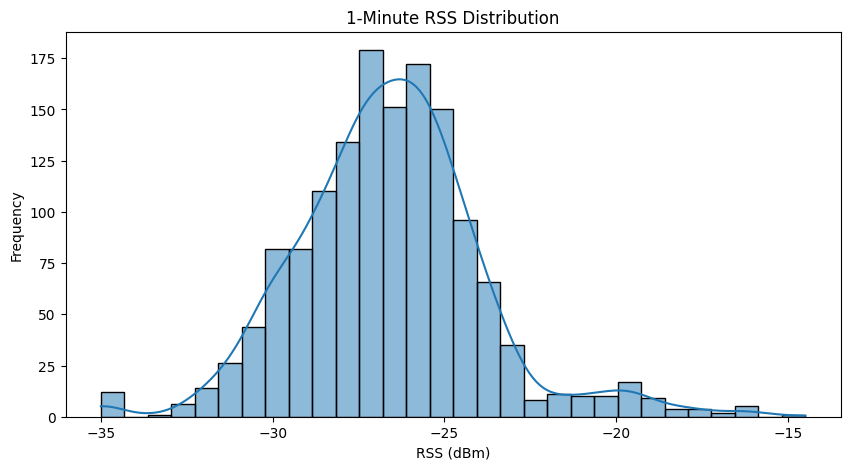

In [ ]:
plt.figure(figsize=(10,5))
sns.histplot(df_1min['RSS'], kde=True, bins=30)
plt.title('1-Minute RSS Distribution')
plt.xlabel('RSS (dBm)')
plt.ylabel('Frequency')
plt.show()

### **C. Boxplot: Outlier Detection**
Purpose:
Identify outliers and variability in RSS.

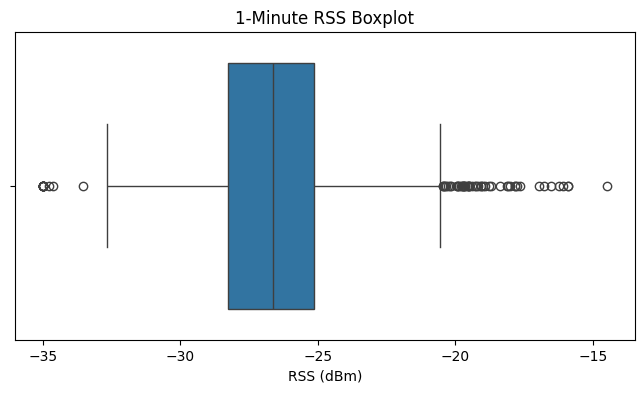

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df_1min['RSS'])
plt.title('1-Minute RSS Boxplot')
plt.xlabel('RSS (dBm)')
plt.show()


### **D. Heatmap: Hourly RSS Patterns**
Purpose:
Visualize daily or hourly patterns in RSS (e.g., due to human activity).

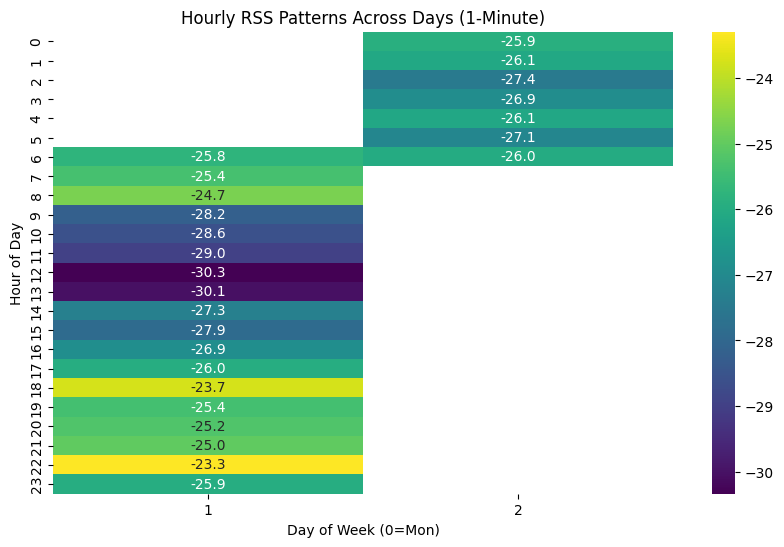

In [ ]:
df_1min['hour'] = df_1min['Timestamp'].dt.hour
df_1min['dayofweek'] = df_1min['Timestamp'].dt.dayofweek
pivot = df_1min.pivot_table(values='RSS', index='hour', columns='dayofweek')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap='viridis', annot=True, fmt=".1f")
plt.title('Hourly RSS Patterns Across Days (1-Minute)')
plt.xlabel('Day of Week (0=Mon)')
plt.ylabel('Hour of Day')
plt.show()


### **E. Autocorrelation Plot**
Purpose:
Assess temporal dependencies and help select LSTM window size.

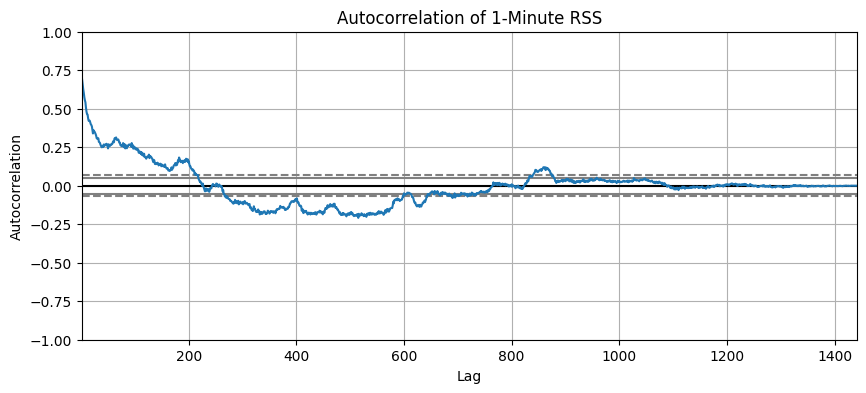

In [ ]:
plt.figure(figsize=(10,4))
autocorrelation_plot(df_1min['RSS'])
plt.title('Autocorrelation of 1-Minute RSS')
plt.show()


### **F. Rolling Mean & Std Visualization**
Purpose:
Identify trends and seasonality.

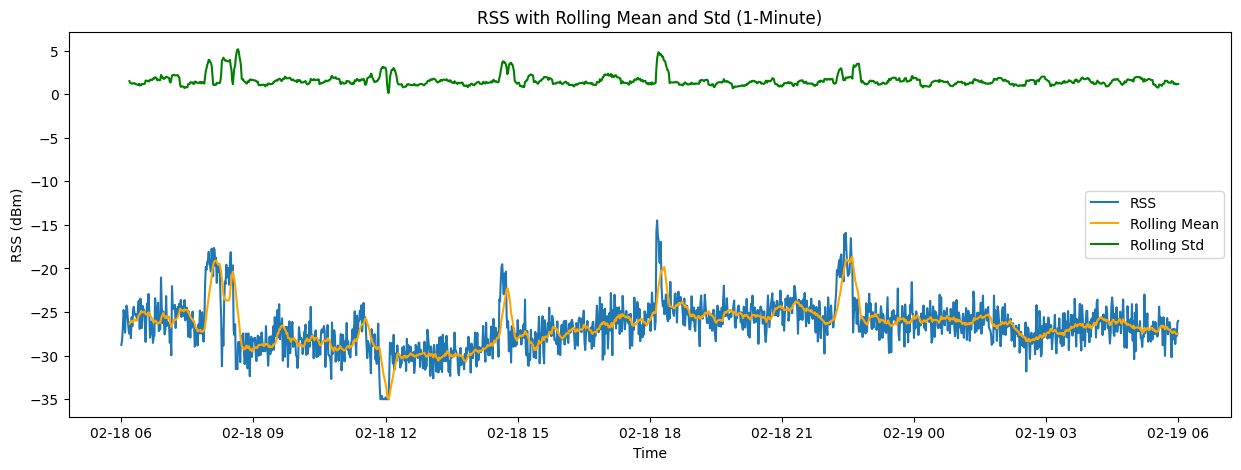

In [ ]:
window = 12  # e.g., 12 for 1 hour if 5-min interval; adjust for 1-min/5-min/10-min
df_1min['rolling_mean'] = df_1min['RSS'].rolling(window=window).mean()
df_1min['rolling_std'] = df_1min['RSS'].rolling(window=window).std()

plt.figure(figsize=(15,5))
plt.plot(df_1min['Timestamp'], df_1min['RSS'], label='RSS')
plt.plot(df_1min['Timestamp'], df_1min['rolling_mean'], label='Rolling Mean', color='orange')
plt.plot(df_1min['Timestamp'], df_1min['rolling_std'], label='Rolling Std', color='green')
plt.title('RSS with Rolling Mean and Std (1-Minute)')
plt.xlabel('Time')
plt.ylabel('RSS (dBm)')
plt.legend()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load timestamps from your previous dataset
df_prev = pd.read_csv('Continuous_Averaged_Transmitter_Data.csv')
df_prev['Timestamp'] = pd.to_datetime(df_prev['Timestamp'])
df_prev = df_prev.sort_values('Timestamp').reset_index(drop=True)
num_points = len(df_prev)

# Set random seed for reproducibility
np.random.seed(42)

# 1. Base RSS level (e.g., -60 dBm)
base_rss = -26

# 2. Slow drift (random walk, simulating environment changes)
slow_drift = np.cumsum(np.random.normal(0, 0.02, num_points))

# 3. Multipath fading (fast, small fluctuations)
multipath = np.random.normal(0, 2, num_points)

# 4. Abrupt events (simulate people moving, doors, etc.)
abrupt_events = np.zeros(num_points)
event_indices = np.random.choice(np.arange(100, num_points-100), size=10, replace=False)
for idx in event_indices:
    duration = np.random.randint(10, 50)  # duration in samples (e.g., 5–25 min if 30s interval)
    magnitude = np.random.uniform(-10, 10)  # dB change
    abrupt_events[idx:idx+duration] += magnitude

# 5. Shadowing (long-term correlated noise)
shadowing = np.cumsum(np.random.normal(0, 0.1, num_points))

# Combine all effects
rss_simulated = base_rss + slow_drift + multipath + abrupt_events + shadowing

# Clip to realistic range
rss_simulated = np.clip(rss_simulated, -35, 0)

# Create DataFrame
simulated_df = pd.DataFrame({'Timestamp': df_prev['Timestamp'], 'RSS': rss_simulated})

# Plot to visualize
plt.figure(figsize=(15,5))
plt.plot(simulated_df['Timestamp'], simulated_df['RSS'], label='Simulated Realistic RSS')
plt.title('Simulated Realistic RSS Signal Strength Over Time')
plt.xlabel('Time')
plt.ylabel('RSS (dBm)')
plt.legend()
plt.show()

# Save to CSV for your use
simulated_df.to_csv('simulated_realistic_rss.csv', index=False)
simulated_df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'Continuous_Averaged_Transmitter_Data.csv'

# **📊 LSTM RSS Prediction:📈 Multi-Horizon LSTM for RSS Forecasting & Model Building (1, 5, 10 min)**
## **1. Sequence Preparation for Multi-Horizon Forecasting**
Goal:
Prepare input sequences (past RSS values) and targets (future RSS at 1, 5, and 10 minutes) for supervised LSTM training.

Explanation:
You want to use the past N minutes (e.g., 12 minutes) to predict RSS at 1, 5, and 10 minutes into the future. This is called multi-horizon forecasting.

In [ ]:
import numpy as np
import pandas as pd

# Use your actual normalized 1-min RSS data from df_1min['RSS_scaled']
# For demonstration, let's simulate similar data:
# num_points_per_day = 1440  # 24 hours * 60 minutes
# np.random.seed(42)
# rss_scaled = np.clip(np.random.normal(0.5, 0.1, num_points_per_day), 0, 1)  # Replace with df_1min['RSS_scaled'].values
rss_scaled = df_1min['RSS_scaled'].values


def create_multi_horizon_sequences(data, look_back=12, horizons=[1,5,10]):
    """
    data: 1D array-like, normalized RSS values
    look_back: number of past time steps to use as input
    horizons: list of forecast horizons (in time steps)
    """
    X = []
    y = {h: [] for h in horizons}
    max_horizon = max(horizons)
    for i in range(len(data) - look_back - max_horizon + 1):
        X.append(data[i:i+look_back])
        for h in horizons:
            y[h].append(data[i+look_back+h-1])
    X = np.array(X)
    for h in horizons:
        y[h] = np.array(y[h])
    return X, y

look_back = 30  # 12 minutes look-back window
horizons = [1, 5, 10]  # 1-min, 5-min, 10-min ahead

X, y = create_multi_horizon_sequences(rss_scaled, look_back, horizons)

# Reshape X for LSTM input: (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into train and test sets (80/20 split)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train = {h: y[h][:train_size] for h in horizons}
y_test = {h: y[h][train_size:] for h in horizons}

# Output shapes for verification
print(f"X_train shape: {X_train.shape}")
for h in horizons:
    print(f"y_train[{h}] shape: {y_train[h].shape}")


X_train shape: (1121, 30, 1)
y_train[1] shape: (1121,)
y_train[5] shape: (1121,)
y_train[10] shape: (1121,)


## **2. Multi-Horizon LSTM Model Building**
Explanation:
A shared LSTM backbone with multiple dense outputs (one per horizon) is a best practice for multi-horizon time-series forecasting.
We use two LSTM layers (128, 64 units), dropout for regularization, and a dense output for each forecast horizon.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

def build_multi_horizon_lstm(input_shape, horizons):
    """
    input_shape: tuple, shape of input sequence (look_back, features)
    horizons: list of forecast horizons
    """
    inputs = Input(shape=input_shape)
    x = LSTM(128, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = LSTM(64)(x)
    x = Dropout(0.3)(x)
    outputs = [Dense(1, name=f'output_{h}')(x) for h in horizons]
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # (look_back, features)
model = build_multi_horizon_lstm(input_shape, horizons)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 128)   │     66,560 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 128)   │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_1 (Dense)    │ (None, 1)         │         65 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_5 (Dense)    │ (None, 1)         │         65 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_10 (Dense)   │ (None, 1)         │         65 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 116,163 (453.76 KB)

 Trainable params: 116,163 (453.76 KB)

 Non-trainable params: 0 (0.00 B)

## **3. Model Training**
Best Practice:
Use early stopping and validation split to prevent overfitting and monitor validation loss.

Explanation:
We use early stopping to avoid overfitting. The model is trained to predict RSS at 1, 5, and 10 minutes ahead, using the past 30 minutes as input.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

y_train_list = [y_train[h] for h in horizons]

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Uncomment to train (do this in the next step with evaluation/visualization)
history = model.fit(
    X_train, y_train_list,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=2
)


Epoch 1/100
28/28 - 6s - 214ms/step - loss: 0.1225 - output_10_loss: 0.0442 - output_1_loss: 0.0385 - output_5_loss: 0.0398 - val_loss: 0.0450 - val_output_10_loss: 0.0144 - val_output_1_loss: 0.0151 - val_output_5_loss: 0.0117
Epoch 2/100
28/28 - 2s - 55ms/step - loss: 0.0530 - output_10_loss: 0.0187 - output_1_loss: 0.0163 - output_5_loss: 0.0180 - val_loss: 0.0394 - val_output_10_loss: 0.0151 - val_output_1_loss: 0.0089 - val_output_5_loss: 0.0125
Epoch 3/100
28/28 - 1s - 46ms/step - loss: 0.0508 - output_10_loss: 0.0199 - output_1_loss: 0.0140 - output_5_loss: 0.0169 - val_loss: 0.0367 - val_output_10_loss: 0.0148 - val_output_1_loss: 0.0077 - val_output_5_loss: 0.0114
Epoch 4/100
28/28 - 2s - 63ms/step - loss: 0.0499 - output_10_loss: 0.0190 - output_1_loss: 0.0142 - output_5_loss: 0.0168 - val_loss: 0.0372 - val_output_10_loss: 0.0148 - val_output_1_loss: 0.0081 - val_output_5_loss: 0.0113
Epoch 5/100
28/28 - 2s - 82ms/step - loss: 0.0488 - output_10_loss: 0.0180 - output_1_loss:

## **4. Training and Validation Loss Visualization**
Explanation:
Visualizing loss curves helps diagnose overfitting and convergence.

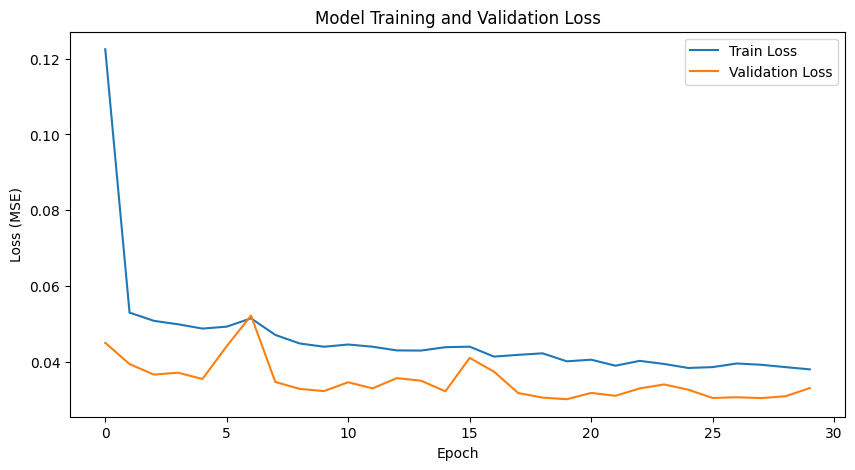

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()


## **5. Model Evaluation: Multi-Metric Assessment**
Explanation:
We compute RMSE, MAE, and R² (coefficient of determination) for each forecast horizon.
If you scaled your RSS with MinMaxScaler, remember to invert the scaling for interpretation in dBm.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test set
y_pred_scaled = model.predict(X_test)

# Invert scaling (if you used MinMaxScaler, e.g., scaler_1min.inverse_transform)
def inverse_transform(y_scaled, scaler):
    return scaler.inverse_transform(y_scaled.reshape(-1, 1)).flatten()

# Example: if you used scaler_1min for 1-min data
# y_true_inv = inverse_transform(y_true, scaler_1min)

# For demonstration, assume data is already in original units
for i, h in enumerate(horizons):
    y_true = y_test[h]
    y_pred = y_pred_scaled[i].flatten()

    # If you used scaling, uncomment the next lines:
    y_true = inverse_transform(y_true, scaler_1min)
    y_pred = inverse_transform(y_pred, scaler_1min)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'Horizon {h} min: RMSE = {rmse:.4f}, MAE = {mae:.4f}, R² = {r2:.4f}')


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Horizon 1 min: RMSE = 1.5379, MAE = 1.2193, R² = 0.0317
Horizon 5 min: RMSE = 1.5043, MAE = 1.2055, R² = 0.0621
Horizon 10 min: RMSE = 1.5141, MAE = 1.2076, R² = 0.0468


## **6. Visualization: True vs Predicted for Each Horizon**
Explanation:
Visualize the first 100 predictions for each horizon to inspect model behavior.

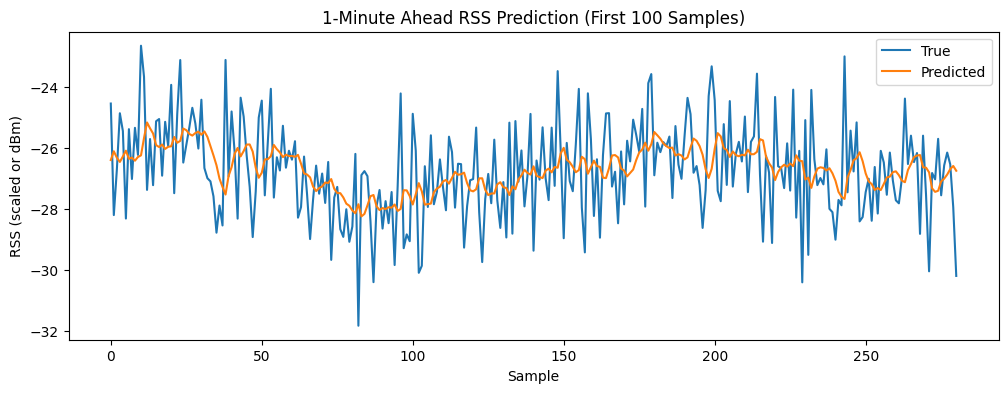

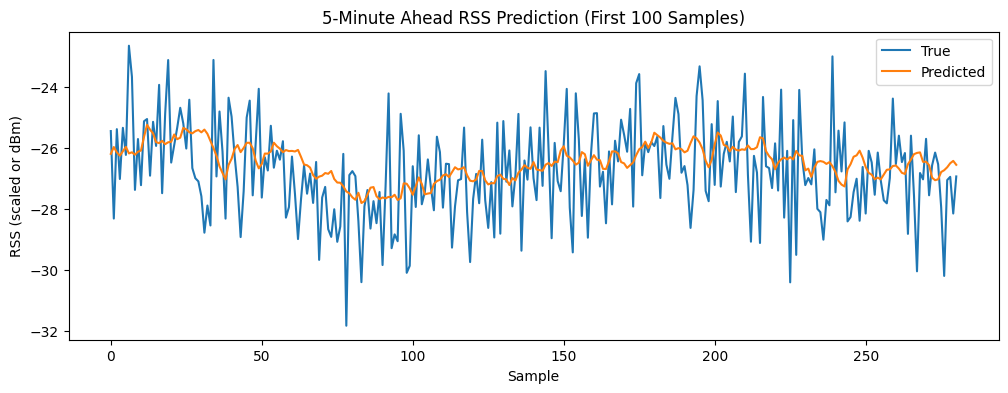

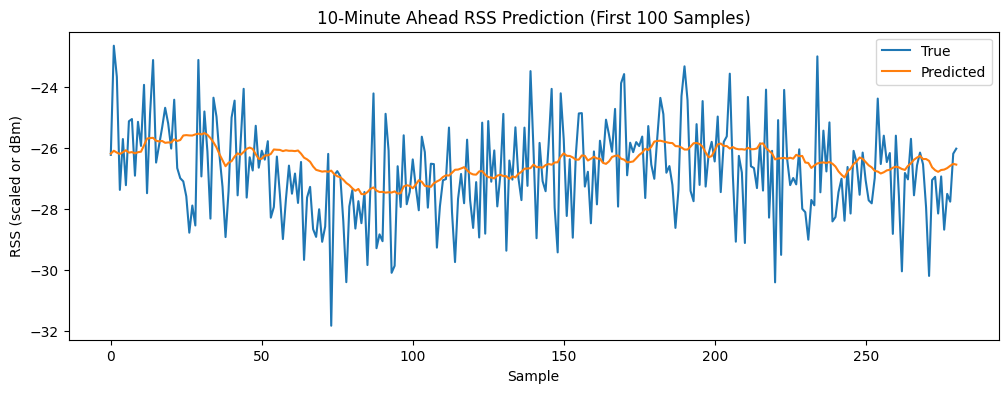

In [ ]:
for i, h in enumerate(horizons):
    y_true = y_test[h]
    y_pred = y_pred_scaled[i].flatten()

    # If you used scaling, uncomment the next lines:
    y_true = inverse_transform(y_true, scaler_1min)
    y_pred = inverse_transform(y_pred, scaler_1min)

    plt.figure(figsize=(12,4))
    plt.plot(y_true[:], label='True')
    plt.plot(y_pred[:], label='Predicted')
    plt.title(f'{h}-Minute Ahead RSS Prediction (First 100 Samples)')
    plt.xlabel('Sample')
    plt.ylabel('RSS (scaled or dBm)')
    plt.legend()
    plt.show()


## **7. Additional Visualization: Error Distribution**
Explanation:
Plot the error distribution to see if the model is biased or has heavy tails.

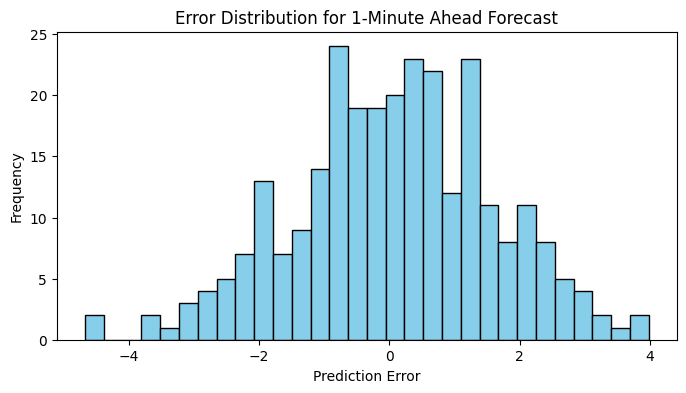

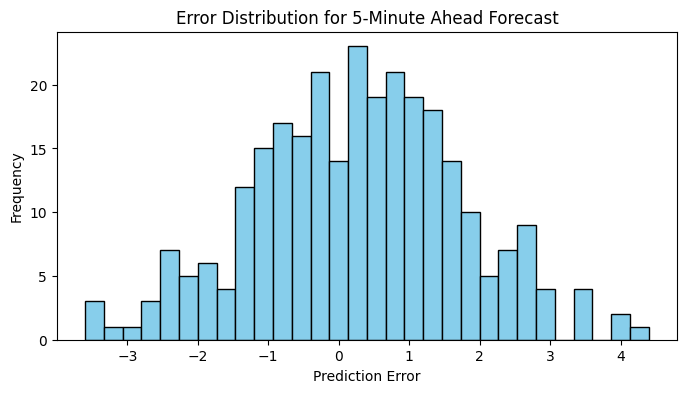

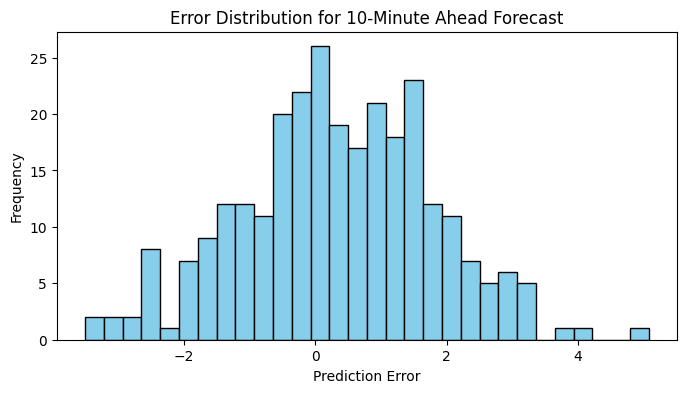

In [ ]:
for i, h in enumerate(horizons):
    y_true = y_test[h]
    y_pred = y_pred_scaled[i].flatten()

    # If you used scaling, uncomment the next lines:
    y_true = inverse_transform(y_true, scaler_1min)
    y_pred = inverse_transform(y_pred, scaler_1min)

    errors = y_pred - y_true
    plt.figure(figsize=(8,4))
    plt.hist(errors, bins=30, color='skyblue', edgecolor='k')
    plt.title(f'Error Distribution for {h}-Minute Ahead Forecast')
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.show()


## **8. Save the Model for Future Use**

In [ ]:
model.save('multi_horizon_lstm_rss.keras')
